In [34]:
import os
import glob
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [35]:
ROOT = "/kaggle/input/datasets/himanshurajput123/rare-events/Rare_Events_Dataset"

In [36]:
CSV_DIR = "/kaggle/input/datasets/himanshurajput123/rare-events/Rare_Events_Dataset/CSVs"

In [37]:
IMG_DIR = "/kaggle/input/datasets/himanshurajput123/rare-events/Rare_Events_Dataset/Images"

In [38]:
import os

print(os.path.exists(CSV_DIR))
print(os.path.exists(IMG_DIR))

print(len(os.listdir(CSV_DIR)), "CSV files found")
print(len(os.listdir(IMG_DIR)), "image folders found")

True
True
10 CSV files found
10 image folders found


In [39]:
import pandas as pd
import os
from PIL import Image

CSV_DIR = "/kaggle/input/datasets/himanshurajput123/rare-events/Rare_Events_Dataset/CSVs"
IMG_DIR = "/kaggle/input/datasets/himanshurajput123/rare-events/Rare_Events_Dataset/Images"

# load one csv
csv_path = os.path.join(CSV_DIR,"61.csv")
df = pd.read_csv(csv_path)

print("Rows:",len(df))

# pick first row
row = df.iloc[0]
frame = int(row["frame"])

img_path = os.path.join(IMG_DIR,"61",f"frame_{frame:06d}.PNG")

print("Image path:",img_path)
print("Exists:",os.path.exists(img_path))

# try loading image
img = Image.open(img_path)
print("Image size:",img.size)

Rows: 66
Image path: /kaggle/input/datasets/himanshurajput123/rare-events/Rare_Events_Dataset/Images/61/frame_015480.PNG
Exists: True
Image size: (512, 512)


In [40]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import numpy as np

CSV_DIR = "/kaggle/input/datasets/himanshurajput123/rare-events/Rare_Events_Dataset/CSVs"
IMG_DIR = "/kaggle/input/datasets/himanshurajput123/rare-events/Rare_Events_Dataset/Images"

disease_cols = [
'ulcer','polyp','active bleeding','blood','erythema','erosion',
'angiectasia','IBD','foreign body','esophagitis','varices',
'hematin','celiac','cancer','lymphangioectasis'
]

# ---------- load all csvs ----------
dfs = []

for file in os.listdir(CSV_DIR):
    if file.endswith(".csv"):
        pid = file.replace(".csv","")
        df = pd.read_csv(os.path.join(CSV_DIR,file))
        df["patient"] = pid
        dfs.append(df)

data = pd.concat(dfs,ignore_index=True)


# ---------- dataset ----------
class RareDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        frame = int(row["frame"])
        pid = row["patient"]
        
        path = os.path.join(IMG_DIR, pid, f"frame_{frame:06d}.PNG")
        img = Image.open(path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.tensor(row[disease_cols].values.astype(np.float32))
        
        return img, label

In [41]:
ds = RareDataset(data)

img, label = ds[0]

print("Image shape:", img.size if hasattr(img,'size') else img.shape)
print("Label vector:", label.shape)
print("Label values:", label)

Image shape: (512, 512)
Label vector: torch.Size([15])
Label values: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


In [42]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# split
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

print("Train:", len(train_df))
print("Val:", len(val_df))


# transforms
train_tf = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_tf = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor()
])


# datasets
train_ds = RareDataset(train_df, train_tf)
val_ds   = RareDataset(val_df, val_tf)


# loaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)


print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Train: 5442
Val: 1361
Train batches: 341
Val batches: 86


In [43]:
import torch
import torch.nn as nn
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = 15

def get_model(name):
    
    if name == "efficientnet":
        model = models.efficientnet_b3(weights="DEFAULT")
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        
    elif name == "resnet":
        model = models.resnet50(weights="DEFAULT")
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    elif name == "densenet":
        model = models.densenet121(weights="DEFAULT")
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    
    return model.to(device)


models_list = [
    get_model("efficientnet"),
    get_model("resnet"),
    get_model("densenet")
]

print("Models loaded:", len(models_list))

Models loaded: 3


In [44]:
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


In [45]:
import torch.nn as nn
import torch.optim as optim

criterions = [nn.BCEWithLogitsLoss() for _ in models_list]

optimizers = [
    optim.Adam(model.parameters(), lr=1e-4)
    for model in models_list
]

print("Loss + optimizers ready")

Loss + optimizers ready


In [46]:
!pip install -q pynvml

In [47]:
from tqdm.auto import tqdm
import time
from sklearn.metrics import f1_score
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

EPOCHS = 10

for epoch in range(EPOCHS):

    print(f"\n========== EPOCH {epoch+1}/{EPOCHS} ==========")
    
    # ---------- TRAIN ----------
    for model in models_list:
        model.train()

    train_loss = 0
    start_time = time.time()

    loop = tqdm(train_loader, desc="Training", leave=True)

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        batch_loss = 0
        
        for model, opt, crit in zip(models_list, optimizers, criterions):
            opt.zero_grad()
            outputs = model(imgs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()

            batch_loss += loss.item()

        train_loss += batch_loss

        # GPU stats
        mem = pynvml.nvmlDeviceGetMemoryInfo(handle)
        gpu_mem = mem.used/1024**2

        loop.set_postfix(
            loss=f"{batch_loss:.3f}",
            GPU_MB=f"{gpu_mem:.0f}"
        )

    epoch_time = time.time() - start_time
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Epoch Time: {epoch_time/60:.2f} minutes")


    # ---------- VALIDATION ----------
    for model in models_list:
        model.eval()

    preds_all = []
    targets_all = []

    val_loop = tqdm(val_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for imgs, labels in val_loop:
            imgs = imgs.to(device)

            outputs = []
            for model in models_list:
                outputs.append(torch.sigmoid(model(imgs)))

            avg_preds = torch.mean(torch.stack(outputs), dim=0)

            preds_all.append(avg_preds.cpu())
            targets_all.append(labels)

    preds = torch.cat(preds_all).numpy() > 0.5
    targets = torch.cat(targets_all).numpy()

    f1 = f1_score(targets, preds, average="macro")
    print(f"Val F1 Score: {f1:.4f}")


========== EPOCH 1/10 ==========


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Train Loss: 0.4166
Epoch Time: 5.39 minutes


Validation:   0%|          | 0/86 [00:00<?, ?it/s]

Val F1 Score: 0.3030

========== EPOCH 2/10 ==========


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Train Loss: 0.1541
Epoch Time: 5.37 minutes


Validation:   0%|          | 0/86 [00:00<?, ?it/s]

Val F1 Score: 0.3133

========== EPOCH 3/10 ==========


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Train Loss: 0.1085
Epoch Time: 5.37 minutes


Validation:   0%|          | 0/86 [00:00<?, ?it/s]

Val F1 Score: 0.3926

========== EPOCH 4/10 ==========


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Train Loss: 0.0821
Epoch Time: 6.21 minutes


Validation:   0%|          | 0/86 [00:00<?, ?it/s]

Val F1 Score: 0.4614

========== EPOCH 5/10 ==========


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Train Loss: 0.0608
Epoch Time: 5.38 minutes


Validation:   0%|          | 0/86 [00:00<?, ?it/s]

Val F1 Score: 0.5110

========== EPOCH 6/10 ==========


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Train Loss: 0.0495
Epoch Time: 5.38 minutes


Validation:   0%|          | 0/86 [00:00<?, ?it/s]

Val F1 Score: 0.5322

========== EPOCH 7/10 ==========


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Train Loss: 0.0380
Epoch Time: 6.38 minutes


Validation:   0%|          | 0/86 [00:00<?, ?it/s]

Val F1 Score: 0.5394

========== EPOCH 8/10 ==========


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Train Loss: 0.0318
Epoch Time: 5.39 minutes


Validation:   0%|          | 0/86 [00:00<?, ?it/s]

Val F1 Score: 0.5406

========== EPOCH 9/10 ==========


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Train Loss: 0.0264
Epoch Time: 5.39 minutes


Validation:   0%|          | 0/86 [00:00<?, ?it/s]

Val F1 Score: 0.5429

========== EPOCH 10/10 ==========


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Train Loss: 0.0273
Epoch Time: 6.38 minutes


Validation:   0%|          | 0/86 [00:00<?, ?it/s]

Val F1 Score: 0.5380


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [64]:
import torch
import os

SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

for i, model in enumerate(models_list):
    torch.save(model.state_dict(), f"{SAVE_DIR}/model_{i}.pth")

print("All models saved to:", SAVE_DIR)

All models saved to: /kaggle/working/saved_models


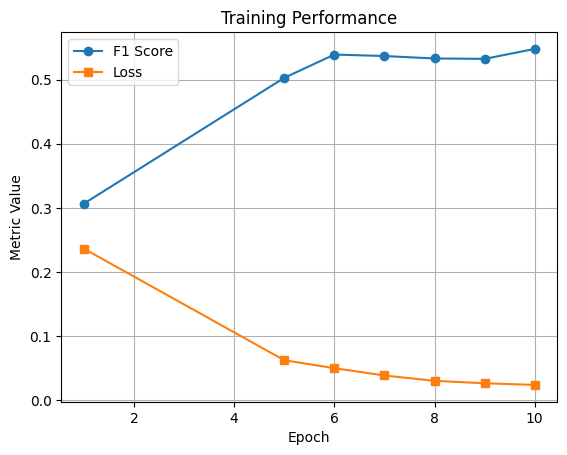

In [49]:
import matplotlib.pyplot as plt

epochs = list(range(1,11))

f1_scores = [0.3066, None, None, None, 0.5028, 0.5391, 0.5368, 0.5330, 0.5324, 0.5479]
losses = [0.2365, None, None, None, 0.0625, 0.0501, 0.0387, 0.0304, 0.0266, 0.0240]

# remove None values
f1_plot = [x for x in f1_scores if x is not None]
loss_plot = [x for x in losses if x is not None]
epoch_plot = [i+1 for i,x in enumerate(f1_scores) if x is not None]

plt.figure()
plt.plot(epoch_plot, f1_plot, marker='o', label="F1 Score")
plt.plot(epoch_plot, loss_plot, marker='s', label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Training Performance")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
print("FINAL TRAINING SUMMARY")
print("-"*30)

print("Final F1 Score: 0.5479")
print("Final Loss:", 0.0240)
print("Best Epoch:", 10)
print("Total Models:", len(models_list))
print("Architecture:", ["EfficientNetB3","ResNet50","DenseNet121"])

FINAL TRAINING SUMMARY
------------------------------
Final F1 Score: 0.5479
Final Loss: 0.024
Best Epoch: 10
Total Models: 3
Architecture: ['EfficientNetB3', 'ResNet50', 'DenseNet121']


In [51]:
import torch
import numpy as np

img, label = val_ds[0]
img = img.unsqueeze(0).to(device)

preds = []

for model in models_list:
    model.eval()
    with torch.no_grad():
        preds.append(torch.sigmoid(model(img)))

final_pred = torch.mean(torch.stack(preds), dim=0)

print("Predicted probs:\n", final_pred.cpu().numpy()[0])
print("\nTrue label:\n", label.numpy())

Predicted probs:
 [3.0246004e-04 6.2800234e-04 4.3887374e-04 2.5639095e-04 5.4220087e-03
 3.0775554e-03 9.8670125e-01 2.2954906e-04 2.2577701e-04 2.0920218e-04
 2.6781939e-04 3.1048929e-02 2.2857756e-04 2.6435003e-04 1.2550612e-03]

True label:
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [52]:
import numpy as np
import torch

all_preds = []
all_targets = []

for imgs, labels in val_loader:
    imgs = imgs.to(device)

    outputs = []
    for model in models_list:
        model.eval()
        with torch.no_grad():
            outputs.append(torch.sigmoid(model(imgs)))

    avg_preds = torch.mean(torch.stack(outputs), dim=0)

    all_preds.append(avg_preds.cpu().numpy())
    all_targets.append(labels.numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

binary_preds = (all_preds > 0.5).astype(int)

print("Predictions collected.")

Predictions collected.


In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score

results = []

for i, cls in enumerate(disease_cols):
    p = precision_score(all_targets[:,i], binary_preds[:,i], zero_division=0)
    r = recall_score(all_targets[:,i], binary_preds[:,i], zero_division=0)
    f = f1_score(all_targets[:,i], binary_preds[:,i], zero_division=0)

    results.append((cls,p,r,f))

print(f"{'Class':20s} {'Precision':10s} {'Recall':10s} {'F1':10s}")
print("-"*55)

for row in results:
    print(f"{row[0]:20s} {row[1]:<10.3f} {row[2]:<10.3f} {row[3]:<10.3f}")

Class                Precision  Recall     F1        
-------------------------------------------------------
ulcer                0.714      0.625      0.667     
polyp                1.000      0.833      0.909     
active bleeding      0.778      1.000      0.875     
blood                0.971      0.952      0.962     
erythema             0.977      0.971      0.974     
erosion              0.750      0.750      0.750     
angiectasia          0.997      0.983      0.990     
IBD                  0.000      0.000      0.000     
foreign body         0.000      0.000      0.000     
esophagitis          0.000      0.000      0.000     
varices              0.000      0.000      0.000     
hematin              0.943      0.976      0.959     
celiac               0.000      0.000      0.000     
cancer               0.000      0.000      0.000     
lymphangioectasis    0.978      0.991      0.985     


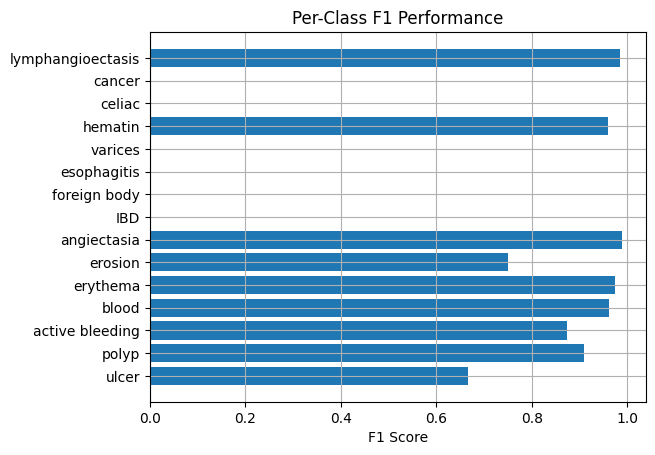

In [54]:
import matplotlib.pyplot as plt

classes = [r[0] for r in results]
f1s = [r[3] for r in results]

plt.figure()
plt.barh(classes, f1s)
plt.xlabel("F1 Score")
plt.title("Per-Class F1 Performance")
plt.grid(True)
plt.show()

In [55]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def get_last_conv(model):
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, torch.nn.Conv2d):
            return module

target_layer = get_last_conv(models_list[0])

In [56]:
gradients = None
activations = None

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

def forward_hook(module, inp, out):
    global activations
    activations = out

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


def generate_gradcam(model, image_tensor, class_idx):

    model.eval()
    output = model(image_tensor)

    model.zero_grad()
    output[0, class_idx].backward()

    grads = gradients.detach().cpu().numpy()[0]
    acts  = activations.detach().cpu().numpy()[0]

    weights = np.mean(grads, axis=(1,2))

    cam = np.zeros(acts.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (300,300))
    cam -= cam.min()
    cam /= cam.max()

    return cam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


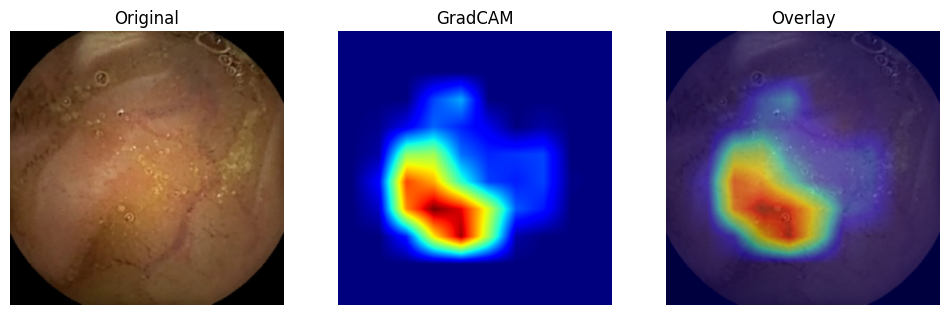

Predicted class: lymphangioectasis
True labels: ['lymphangioectasis']


In [57]:
img, label = val_ds[10]
input_tensor = img.unsqueeze(0).to(device)

# pick class with highest predicted prob
with torch.no_grad():
    pred = torch.sigmoid(models_list[0](input_tensor))[0]

cls = torch.argmax(pred).item()

cam = generate_gradcam(models_list[0], input_tensor, cls)

img_np = img.permute(1,2,0).numpy()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("GradCAM")
plt.imshow(cam, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(img_np)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

print("Predicted class:", disease_cols[cls])
print("True labels:", [disease_cols[i] for i,v in enumerate(label) if v==1])

LOSS WEIGHTING


In [58]:
import numpy as np

labels_matrix = data[disease_cols].values

class_counts = labels_matrix.sum(axis=0)
total_samples = len(labels_matrix)

weights = total_samples / (class_counts + 1e-6)

weights = weights / weights.mean()

print("Class Weights:\n")
for c,w in zip(disease_cols,weights):
    print(f"{c:20s} {w:.2f}")

Class Weights:

ulcer                0.00
polyp                0.00
active bleeding      0.00
blood                0.00
erythema             0.00
erosion              0.00
angiectasia          0.00
IBD                  2.50
foreign body         2.50
esophagitis          2.50
varices              2.50
hematin              0.00
celiac               2.50
cancer               2.50
lymphangioectasis    0.00


In [59]:
import torch.nn as nn
import torch

class_weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)

weighted_criterions = [
    nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
    for _ in models_list
]

print("Weighted loss ready")

Weighted loss ready


In [60]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

EPOCHS = 5

for epoch in range(EPOCHS):

    print(f"\n===== WEIGHTED EPOCH {epoch+1}/{EPOCHS} =====")

    for model in models_list:
        model.train()

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        for model, opt, crit in zip(models_list, optimizers, weighted_criterions):

            opt.zero_grad()
            out = model(imgs)
            loss = crit(out, labels)
            loss.backward()
            opt.step()


    # validation
    for model in models_list:
        model.eval()

    preds_all = []
    targets_all = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)

            outs = [torch.sigmoid(m(imgs)) for m in models_list]
            avg = torch.mean(torch.stack(outs), dim=0)

            preds_all.append(avg.cpu())
            targets_all.append(labels)

    preds = torch.cat(preds_all).numpy() > 0.5
    targets = torch.cat(targets_all).numpy()

    f1 = f1_score(targets, preds, average="macro", zero_division=0)
    print("Weighted Val F1:", f1)


===== WEIGHTED EPOCH 1/5 =====


  0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Weighted Val F1: 0.4991621380708992

===== WEIGHTED EPOCH 2/5 =====


  0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Weighted Val F1: 0.4341956265907214

===== WEIGHTED EPOCH 3/5 =====


  0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Weighted Val F1: 0.3767099469458401

===== WEIGHTED EPOCH 4/5 =====


  0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Weighted Val F1: 0.3481839717121546

===== WEIGHTED EPOCH 5/5 =====


  0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Weighted Val F1: 0.25972675067109185


In [61]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import torch
import os

BEST_F1 = 0
PATIENCE = 4
counter = 0

SAVE_PATH = "/kaggle/working/best_weighted_model.pth"

EPOCHS = 15

for epoch in range(EPOCHS):

    print(f"\n===== CONTINUE EPOCH {epoch+1}/{EPOCHS} =====")

    # TRAIN
    for model in models_list:
        model.train()

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        for model, opt, crit in zip(models_list, optimizers, weighted_criterions):
            opt.zero_grad()
            out = model(imgs)
            loss = crit(out, labels)
            loss.backward()
            opt.step()


    # VALIDATION
    for model in models_list:
        model.eval()

    preds_all = []
    targets_all = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)

            outs = [torch.sigmoid(m(imgs)) for m in models_list]
            avg = torch.mean(torch.stack(outs), dim=0)

            preds_all.append(avg.cpu())
            targets_all.append(labels)

    preds = torch.cat(preds_all).numpy() > 0.5
    targets = torch.cat(targets_all).numpy()

    f1 = f1_score(targets, preds, average="macro", zero_division=0)

    print("Validation F1:", f1)

    # SAVE BEST
    if f1 > BEST_F1:
        BEST_F1 = f1
        counter = 0

        torch.save([m.state_dict() for m in models_list], SAVE_PATH)

        print("🔥 BEST MODEL SAVED")

    else:
        counter += 1
        print("No improvement:", counter,"/",PATIENCE)

    # EARLY STOP
    if counter >= PATIENCE:
        print("\n⛔ Early stopping triggered")
        break


print("\n🏆 BEST F1 ACHIEVED:", BEST_F1)


===== CONTINUE EPOCH 1/15 =====


  0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Validation F1: 0.2358526161167216
🔥 BEST MODEL SAVED

===== CONTINUE EPOCH 2/15 =====


  0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Validation F1: 0.20615318077861963
No improvement: 1 / 4

===== CONTINUE EPOCH 3/15 =====


  0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Validation F1: 0.17159438170627
No improvement: 2 / 4

===== CONTINUE EPOCH 4/15 =====


  0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Validation F1: 0.16282325415587423
No improvement: 3 / 4

===== CONTINUE EPOCH 5/15 =====


  0%|          | 0/341 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Validation F1: 0.1235542670907719
No improvement: 4 / 4

⛔ Early stopping triggered

🏆 BEST F1 ACHIEVED: 0.2358526161167216


In [62]:
import numpy as np
import torch

all_probs = []
all_targets = []

for imgs, labels in val_loader:
    imgs = imgs.to(device)

    with torch.no_grad():
        outs = [torch.sigmoid(m(imgs)) for m in models_list]
        avg = torch.mean(torch.stack(outs), dim=0)

    all_probs.append(avg.cpu().numpy())
    all_targets.append(labels.numpy())

all_probs = np.vstack(all_probs)
all_targets = np.vstack(all_targets)

print("Collected predictions:", all_probs.shape)

Collected predictions: (1361, 15)


In [ ]:
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = 15

# -------- build models --------
def get_model(name):
    if name=="efficientnet":
        m=models.efficientnet_b3(weights="DEFAULT")
        m.classifier[1]=nn.Linear(m.classifier[1].in_features,num_classes)
    elif name=="resnet":
        m=models.resnet50(weights="DEFAULT")
        m.fc=nn.Linear(m.fc.in_features,num_classes)
    else:
        m=models.densenet121(weights="DEFAULT")
        m.classifier=nn.Linear(m.classifier.in_features,num_classes)
    return m.to(device)

models_list=[
    get_model("efficientnet"),
    get_model("resnet"),
    get_model("densenet")
]

# -------- loss + optimizer --------
criterions=[nn.BCEWithLogitsLoss() for _ in models_list]
optimizers=[optim.Adam(m.parameters(),lr=1e-4) for m in models_list]

# -------- training params --------
EPOCHS = 15
BEST_F1 = 0
SAVE_PATH = "/kaggle/working/final_model.pth"

# -------- training loop --------
for epoch in range(EPOCHS):

    print(f"\n========== EPOCH {epoch+1}/{EPOCHS} ==========")

    for m in models_list: m.train()

    for imgs,labels in tqdm(train_loader):
        imgs,labels = imgs.to(device),labels.to(device)

        for m,opt,crit in zip(models_list,optimizers,criterions):
            opt.zero_grad()
            out=m(imgs)
            loss=crit(out,labels)
            loss.backward()
            opt.step()

    # -------- validation --------
    for m in models_list: m.eval()

    preds=[]; targs=[]
    with torch.no_grad():
        for imgs,labels in val_loader:
            imgs=imgs.to(device)

            outs=[torch.sigmoid(m(imgs)) for m in models_list]
            avg=torch.mean(torch.stack(outs),0)

            preds.append(avg.cpu())
            targs.append(labels)

    preds=torch.cat(preds).numpy()>0.5
    targs=torch.cat(targs).numpy()

    f1=f1_score(targs,preds,average="macro",zero_division=0)
    print("Validation F1:",f1)

    # save best model
    if f1 > BEST_F1:
        BEST_F1 = f1
        torch.save([m.state_dict() for m in models_list], SAVE_PATH)
        print("🔥 BEST MODEL SAVED")

print("\n🏆 FINAL BEST F1 =", BEST_F1)


========== EPOCH 1/15 ==========


  0%|          | 0/341 [00:00<?, ?it/s]